# Model Development

In [9]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn import metrics
import statsmodels.api as sm

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures

from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import BaggingRegressor, VotingRegressor

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

from sklearn.pipeline import make_pipeline, Pipeline
from scipy.stats import uniform

import pickle

In [2]:
# Read in the first merged shift dataset (2021, 2022,2023) without weather or any data engineering
shift_df = pd.read_csv('data/shift_details.csv')

In [3]:
shift_df.head()

,SITE_NAME,DATE1,DAY_OF_WEEK,INSPECTOR_ID,PAY_VOL,SHIFT_START,SHIFT_END,TOTALINSP,NUMINVASIVE,TOWN,WATERBODY,SHIFT_LENGTH,DATE,month,year
0,Launch Drive,05/28/2021,Fri,4771,1,12:00,18:00,33.0,0.0,Launch Drive,Cobbosseecontee Lake,360.0,2021-05-28,5,2021
1,East Winthrop,05/28/2021,Fri,4485,1,12:00,18:00,2.0,0.0,Winthrop,Cobbosseecontee Lake,360.0,2021-05-28,5,2021
2,Augusta West Kampground,05/28/2021,Fri,4769,1,12:00,18:00,1.0,0.0,Winthrop,Annabessacook Lake,360.0,2021-05-28,5,2021
3,Whippoorwill Road,05/28/2021,Fri,4174,1,12:00,18:00,13.0,0.0,Litchfield,Woodbury Pond,360.0,2021-05-28,5,2021
4,Thorofare Rd,05/29/2021,Sat,4944,1,07:00,17:00,11.0,0.0,Litchfield,Pleasant Pond,600.0,2021-05-29,5,2021


In [4]:
# Defining X and y
y = shift_df['TOTALINSP']
X = shift_df.drop(columns=['DATE1', 'TOTALINSP', 'NUMINVASIVE', 'TOWN', 'WATERBODY', 'DATE', 'INSPECTOR_ID'])

In [5]:
# Train test split for evaluating model performance
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.3)

In [37]:
X_train

,SITE_NAME,DAY_OF_WEEK,PAY_VOL,SHIFT_START,SHIFT_END,SHIFT_LENGTH,month,year
1510,Old Kents Hill Road,Mon,1,09:00,19:00,600.0,5,2023
1061,Launch Drive Cobbosseecontee,Sun,1,13:00,19:00,360.0,7,2022
2040,East Winthrop Cobbosseecontee,Thu,1,13:00,19:00,360.0,8,2023
123,Whippoorwill Road,Sun,1,13:00,19:00,360.0,6,2021
729,Rt 41 North Basin Maranacook,Sun,1,13:00,19:00,360.0,6,2022
...,...,...,...,...,...,...,...,...
1638,East Winthrop Cobbosseecontee,Tue,1,13:00,19:00,360.0,6,2023
1095,Launch Drive Cobbosseecontee,Fri,1,07:00,13:00,360.0,7,2022
1130,Rt 41 North Basin Maranacook,Sun,1,07:00,13:00,360.0,7,2022
1294,Rt 41 North Basin Maranacook,Sun,1,13:00,19:00,360.0,8,2022


In [12]:
# Calculate the baseline r**2
shift_df['y_preds'] = np.mean(shift_df.TOTALINSP)

In [13]:
metrics.mean_squared_error(shift_df.TOTALINSP, shift_df.y_preds)

294.8412280701754

In [15]:
metrics.r2_score(shift_df.TOTALINSP, shift_df.y_preds)

0.0

The baseline r2 is very low. This means it will be very easy to outperform the baseline, though this will be a very low bar. 

### Modeling Steps:

1. Create benchmark models using the default parameters and without any feature engineering or weather data
2. Add in the weather data and re-run models
3. Add in the engineered variables and re-run models
4. Grid-search and random search over the parameters of the most promising models. 

In [6]:
# Pre-processing

categorical_columns = ['SITE_NAME', 'DAY_OF_WEEK', 'month', 'year']
oh = OneHotEncoder(handle_unknown='ignore', drop='first')
X_train_transformed = oh.fit_transform(X_train[categorical_columns])
X_test_transformed= oh.transform(X_test[categorical_columns])

In [43]:
# Basic Linear Regression Model
lr = LinearRegression()
lr.fit(X_train_transformed, y_train)

LinearRegression()

In [44]:
lr.score(X_train_transformed, y_train)

0.3142477893028155

In [46]:
lr.score(X_test_transformed, y_test)

0.26526984756509553

In [16]:
# Random forest model
rf = RandomForestRegressor(n_estimators=100, n_jobs=2, random_state=42, oob_score=True)
rf.fit(X_train_transformed, y_train)
print(rf.score(X_train_transformed, y_train))
print(rf.score(X_test_transformed, y_test))

0.5823881813796656
0.28061943955375523


In [17]:
# Extra Trees model
et = ExtraTreesRegressor(n_estimators=100, n_jobs=2, random_state=42)
et.fit(X_train_transformed, y_train)
print(et.score(X_train_transformed, y_train))
print(et.score(X_test_transformed, y_test))

0.5982039094617482
0.19747301885075785


Both tree models are very ovefit- adding regularization and gridsearching over to find best params could improve the models and improve the testing r2. However, despite being overfit, the random forest model with an r2 of .28 is promising. Both models are potentially decent starting points and using a combination of new data (weather) and feature engineering (holidays and inspector experience) could further improve the models' success. 

In [20]:
# AdaBoost Model
ada = AdaBoostRegressor()
ada.fit(X_train_transformed, y_train)
print(ada.score(X_train_transformed, y_train))
print(ada.score(X_test_transformed, y_test))

0.1631178499776783
0.057888955598118574


In [22]:
# Gradient Boost Model
grad = GradientBoostingRegressor()
grad.fit(X_train_transformed, y_train)
print(grad.score(X_train_transformed, y_train))
print(grad.score(X_test_transformed, y_test))

0.4110300421256725
0.2711720175379255


In [45]:
# KNN model
sc = StandardScaler(with_mean=False)
sc.fit(X2_train_transformed)
X_train_sc = sc.transform(X2_train_transformed)
X_test_sc = sc.transform(X2_test_transformed)

knn = KNeighborsRegressor()
knn.fit(X_train_sc, y2_train)
print(knn.score(X_train_sc, y2_train))
print(knn.score(X_test_sc, y2_test))

0.5545984630282782
0.41081113978621897


In [49]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3, 4]
}
# Create the KNN model
knn = GridSearchCV(knn, param_grid, cv=5, scoring='r2')

# Create GridSearchCV object
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='r2')


In [50]:
%%time
grid_search.fit(X_train_sc, y2_train)
print(grid_search.score(X_train_sc, y2_train))
print(grid_search.score(X_test_sc, y2_test))
print("Best Parameters:", grid_search.best_params_)
print("Best R^2 Score:", grid_search.best_score_)

ValueError: Invalid parameter 'n_neighbors' for estimator GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
                         'p': [1, 2, 3, 4],
                         'weights': ['uniform', 'distance']},
             scoring='r2'). Valid parameters are: ['cv', 'error_score', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'].

In [51]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3, 4]
}

# Create the KNN model
knn = KNeighborsRegressor()

# Create StandardScaler
sc = StandardScaler(with_mean=False)
sc.fit(X2_train_transformed)
X_train_sc = sc.transform(X2_train_transformed)
X_test_sc = sc.transform(X2_test_transformed)

# Create GridSearchCV object
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='r2')
%time grid_search.fit(X_train_sc, y2_train)

print(grid_search.score(X_train_sc, y2_train))
print(grid_search.score(X_test_sc, y2_test))
print("Best Parameters:", grid_search.best_params_)
print("Best R^2 Score:", grid_search.best_score_)

CPU times: total: 13.9 s
Wall time: 7.44 s
0.4861729171213851
0.4115539078442356
Best Parameters: {'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}
Best R^2 Score: 0.38692820928209193


C:\Users\kaitl\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
140 fits failed out of a total of 280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kaitl\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kaitl\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kaitl\anaconda3\Lib\site-packages\sklearn\neighbors\_regression.py", line 218, in fit
    return se

### Adding weather data

In [2]:
# Reading in the initial df with weather

df = pd.read_csv('data/df_with_weather.csv')

In [3]:
df.head()

,DATE1,DAY_OF_WEEK,SITE_NAME,TOWN,WATERBODY,INSPECTOR_ID,PAY_VOL,SHIFT_START,TRAILERS,SHIFT_END,SHIFT_LENGTH,TOTALINSP,PRCP,TMAX,TMIN,TOBS
0,2021-05-28,Fri,Launch Drive,Monmouth,Cobbosseecontee Lake,4771,Paid,12:00,10.0,18:00,360,33.0,0.00,72.0,45.0,49.0
1,2021-05-28,Fri,Whippoorwill Road,Litchfield,Woodbury Pond,4174,Paid,12:00,1.0,18:00,360,13.0,0.00,72.0,45.0,49.0
2,2021-05-28,Fri,Augusta West Kampground,Winthrop,Annabessacook Lake,4769,Paid,12:00,0.0,18:00,360,1.0,0.00,72.0,45.0,49.0
3,2021-05-28,Fri,East Winthrop,Winthrop,Cobbosseecontee Lake,4485,Paid,12:00,1.0,18:00,360,2.0,0.00,72.0,45.0,49.0
4,2021-05-29,Sat,Thorofare Rd,Litchfield,Pleasant Pond,4944,Paid,7:00,1.0,17:00,600,11.0,0.02,62.0,45.0,46.0


In [96]:
df.drop(columns=['TRAILERS'], inplace=True)

In [97]:
df.isna().sum()

DATE1            0
DAY_OF_WEEK      0
SITE_NAME        0
TOWN             0
WATERBODY        0
INSPECTOR_ID     0
PAY_VOL          0
SHIFT_START      0
SHIFT_END        0
SHIFT_LENGTH     0
TOTALINSP        2
PRCP            27
TMAX            91
TMIN            95
TOBS            55
dtype: int64

In [98]:
df.shape

(2669, 15)

In [99]:
df.dropna(inplace=True)

In [100]:
df.isna().sum()

DATE1           0
DAY_OF_WEEK     0
SITE_NAME       0
TOWN            0
WATERBODY       0
INSPECTOR_ID    0
PAY_VOL         0
SHIFT_START     0
SHIFT_END       0
SHIFT_LENGTH    0
TOTALINSP       0
PRCP            0
TMAX            0
TMIN            0
TOBS            0
dtype: int64

In [101]:
df.shape

(2565, 15)

In [102]:
df.head()

,DATE1,DAY_OF_WEEK,SITE_NAME,TOWN,WATERBODY,INSPECTOR_ID,PAY_VOL,SHIFT_START,SHIFT_END,SHIFT_LENGTH,TOTALINSP,PRCP,TMAX,TMIN,TOBS
0,2021-05-28,Fri,Launch Drive,Monmouth,Cobbosseecontee Lake,4771,Paid,12:00,18:00,360,33.0,0.00,72.0,45.0,49.0
1,2021-05-28,Fri,Whippoorwill Road,Litchfield,Woodbury Pond,4174,Paid,12:00,18:00,360,13.0,0.00,72.0,45.0,49.0
2,2021-05-28,Fri,Augusta West Kampground,Winthrop,Annabessacook Lake,4769,Paid,12:00,18:00,360,1.0,0.00,72.0,45.0,49.0
3,2021-05-28,Fri,East Winthrop,Winthrop,Cobbosseecontee Lake,4485,Paid,12:00,18:00,360,2.0,0.00,72.0,45.0,49.0
4,2021-05-29,Sat,Thorofare Rd,Litchfield,Pleasant Pond,4944,Paid,7:00,17:00,600,11.0,0.02,62.0,45.0,46.0


In [103]:
# Convert 'date1' to datetime
df['DATE'] = pd.to_datetime(df['DATE1'], format='%Y/%m/%d')

# Create 'month' and 'year' columns
df['month'] = df['DATE'].dt.month
df['year'] = df['DATE'].dt.year

In [104]:
df.head()

,DATE1,DAY_OF_WEEK,SITE_NAME,TOWN,WATERBODY,INSPECTOR_ID,PAY_VOL,SHIFT_START,SHIFT_END,SHIFT_LENGTH,TOTALINSP,PRCP,TMAX,TMIN,TOBS,DATE,month,year
0,2021-05-28,Fri,Launch Drive,Monmouth,Cobbosseecontee Lake,4771,Paid,12:00,18:00,360,33.0,0.00,72.0,45.0,49.0,2021-05-28,5,2021
1,2021-05-28,Fri,Whippoorwill Road,Litchfield,Woodbury Pond,4174,Paid,12:00,18:00,360,13.0,0.00,72.0,45.0,49.0,2021-05-28,5,2021
2,2021-05-28,Fri,Augusta West Kampground,Winthrop,Annabessacook Lake,4769,Paid,12:00,18:00,360,1.0,0.00,72.0,45.0,49.0,2021-05-28,5,2021
3,2021-05-28,Fri,East Winthrop,Winthrop,Cobbosseecontee Lake,4485,Paid,12:00,18:00,360,2.0,0.00,72.0,45.0,49.0,2021-05-28,5,2021
4,2021-05-29,Sat,Thorofare Rd,Litchfield,Pleasant Pond,4944,Paid,7:00,17:00,600,11.0,0.02,62.0,45.0,46.0,2021-05-29,5,2021


In [105]:
df.SHIFT_START = pd.to_datetime(df.SHIFT_START, format='%H:%M')

In [106]:
df.SHIFT_END = pd.to_datetime(df.SHIFT_END)

In [107]:
X = df.drop(columns=['DATE1', 'TOWN', 'WATERBODY', 'INSPECTOR_ID', 'TOTALINSP', 'TOBS', 'DATE'])
y = df.TOTALINSP            

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)

In [109]:
categorical_columns = ['SITE_NAME', 'DAY_OF_WEEK', 'month', 'year', 'PAY_VOL']
oh = OneHotEncoder(handle_unknown='ignore', drop='first')
X_train_transformed = oh.fit_transform(X_train[categorical_columns])
X_test_transformed= oh.transform(X_test[categorical_columns])

In [110]:
lr = LinearRegression()
lr.fit(X_train_transformed, y_train)
print(lr.score(X_train_transformed, y_train))
print(lr.score(X_test_transformed, y_test))

0.3513358726642821
0.33841873049366566


In [111]:
rf = RandomForestRegressor()
rf.fit(X_train_transformed, y_train)
print(rf.score(X_train_transformed, y_train))
print(rf.score(X_test_transformed, y_test))      

0.6434682293497731
0.3232590228474176


In [112]:
et = ExtraTreesRegressor()
et.fit(X_train_transformed, y_train)
print(et.score(X_train_transformed, y_train))
print(et.score(X_test_transformed, y_test))

0.6573212547527139
0.25420966053172644


From these initial models, adding weather data seems to improve the model performance significantly. The models become significantly less overfit. The next step will be to try to add in the holidays as another column, and then to use feature engineering with shift length, shift start and shift end to attempt to somehow capture time of day.

The models were all less overfit, however the tree models are still overfit. Parameter optimization could help reduce the overfit as well to balance out the metrics of the tree based models between the training and test scores. 

### Running models with Engineered columns

In [113]:
# Converting times to 'time of day'
df.head(1)

,DATE1,DAY_OF_WEEK,SITE_NAME,TOWN,WATERBODY,INSPECTOR_ID,PAY_VOL,SHIFT_START,SHIFT_END,SHIFT_LENGTH,TOTALINSP,PRCP,TMAX,TMIN,TOBS,DATE,month,year
0,2021-05-28,Fri,Launch Drive,Monmouth,Cobbosseecontee Lake,4771,Paid,1900-01-01 12:00:00,2023-12-03 18:00:00,360,33.0,0.0,72.0,45.0,49.0,2021-05-28,5,2021


In [114]:
df.SHIFT_START.value_counts()

1900-01-01 07:00:00    902
1900-01-01 13:00:00    604
1900-01-01 09:00:00    241
1900-01-01 12:00:00    164
1900-01-01 08:00:00    119
                      ... 
1900-01-01 08:17:00      1
1900-01-01 07:40:00      1
1900-01-01 04:41:00      1
1900-01-01 12:55:00      1
1900-01-01 09:40:00      1
Name: SHIFT_START, Length: 139, dtype: int64

In [115]:
df.dtypes

DATE1                   object
DAY_OF_WEEK             object
SITE_NAME               object
TOWN                    object
WATERBODY               object
INSPECTOR_ID             int64
PAY_VOL                 object
SHIFT_START     datetime64[ns]
SHIFT_END       datetime64[ns]
SHIFT_LENGTH             int64
TOTALINSP              float64
PRCP                   float64
TMAX                   float64
TMIN                   float64
TOBS                   float64
DATE            datetime64[ns]
month                    int64
year                     int64
dtype: object

In [116]:
df['SHIFT_START_CATEGORY'] = pd.cut(pd.to_datetime(df['SHIFT_START'], format='%H:%M').dt.hour,
                                    bins =[-1, 8, 11, 14, 17, 24],
                                    labels=['Early Morning', 'Morning', 'Afternoon', 'Late Afternoon', 'Evening'])
                        

In [117]:
df.isna().sum()

DATE1                   0
DAY_OF_WEEK             0
SITE_NAME               0
TOWN                    0
WATERBODY               0
INSPECTOR_ID            0
PAY_VOL                 0
SHIFT_START             0
SHIFT_END               0
SHIFT_LENGTH            0
TOTALINSP               0
PRCP                    0
TMAX                    0
TMIN                    0
TOBS                    0
DATE                    0
month                   0
year                    0
SHIFT_START_CATEGORY    0
dtype: int64

In [118]:
df.SHIFT_START_CATEGORY.value_counts()

Early Morning     1202
Afternoon          871
Morning            371
Late Afternoon     105
Evening             16
Name: SHIFT_START_CATEGORY, dtype: int64

In [119]:
df['SHIFT_END_CATEGORY'] = pd.cut(pd.to_datetime(df['SHIFT_END'], format='%H:%M').dt.hour,
                                    bins =[-1, 8, 11, 14, 17, 19, 24],
                                    labels=['Early Morning', 'Morning', 'Afternoon', 'Late Afternoon', 'Evening', 'Night'])
                        

In [120]:
df.SHIFT_END_CATEGORY.value_counts()

Evening           1004
Afternoon          810
Late Afternoon     511
Morning            108
Early Morning       88
Night               44
Name: SHIFT_END_CATEGORY, dtype: int64

In [121]:
X1 = df.drop(columns=['DATE1', 'TOWN', 'WATERBODY', 'INSPECTOR_ID', 'TOTALINSP', 'TOBS', 'DATE', 'SHIFT_START', 'SHIFT_END'])
y1 = df.TOTALINSP            

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=42, test_size=.2)

In [122]:
categorical_columns = ['SITE_NAME', 'DAY_OF_WEEK', 'month', 'year', 'PAY_VOL', 'SHIFT_START_CATEGORY', 'SHIFT_END_CATEGORY']
oh = OneHotEncoder(handle_unknown='ignore', drop='first')
X1_train_transformed = oh.fit_transform(X1_train[categorical_columns])
X1_test_transformed= oh.transform(X1_test[categorical_columns])

#### Adding in daypart categories

In [123]:
lr1 = LinearRegression()
lr1.fit(X1_train_transformed, y1_train)
print(lr1.score(X1_train_transformed, y1_train))
print(lr1.score(X1_test_transformed, y1_test))

0.43299897430845313
0.45589238044822944


In [124]:
rf1 = RandomForestRegressor()
rf1.fit(X1_train_transformed, y1_train)
print(rf1.score(X1_train_transformed, y1_train))
print(rf1.score(X1_test_transformed, y1_test))     

0.7985128527367691
0.3845439939140577


In [125]:
et1 =ExtraTreesRegressor()
et1.fit(X1_train_transformed, y1_train)
print(et1.score(X1_train_transformed, y1_train))
print(et1.score(X1_test_transformed, y1_test))      

0.8333177482959641
0.18467138568428598


#### Adding in holidays

In [126]:
# List of holidays
# 2021: Monday, May 31 Memorial Day, Sunday July 4 (Observed Monday), Monday September 6 (Labor Day), Sunday May 9 (Mother's Day), Father's Day (Sunday, June 20)
# 2022: Sunday May 08, Mother's Day, 'Monday May 30 Memorial Day, Monday September 5 Labor Day, Monday July 4, Sunday June 19 Father's Day
# 2023: Monday, May 29 Memorial Day, Monday June19 Juneteenth, Tuesday, July 04, Monday September 04 Labor Day, Mother's Day Sunday May 14, Father's Day Sunday June 18
#'2021-05-09', '2022-05-30', , '2023-06-19'
holiday_list = ['2021-05-31', '2021-07-04', '2021-09-06', '2021-06-20',
                '2022-05-08', '2022-05-30', '2022-07-04', '2022-06-19',
                '2023-05-29', '2023-07-04', '2023-09-04', '2023-06-18']


In [127]:
df['holiday']= np.where(df['DATE'].isin(holiday_list), 1, 0)

In [128]:
df.sample(25)

,DATE1,DAY_OF_WEEK,SITE_NAME,TOWN,WATERBODY,INSPECTOR_ID,PAY_VOL,SHIFT_START,SHIFT_END,SHIFT_LENGTH,...,PRCP,TMAX,TMIN,TOBS,DATE,month,year,SHIFT_START_CATEGORY,SHIFT_END_CATEGORY,holiday
272,2021-07-16,Fri,Augusta West Kampground,Winthrop,Annabessacook Lake,4769,Paid,1900-01-01 12:00:00,2023-12-03 18:00:00,360,...,0.00,88.0,67.0,74.0,2021-07-16,7,2021,Afternoon,Evening,0
1523,2022-08-28,Sun,Launch Drive Cobbosseecontee,Monmouth,Cobbosseecontee Lake,5580,Paid,1900-01-01 07:00:00,2023-12-03 13:00:00,360,...,0.00,78.0,62.0,67.0,2022-08-28,8,2022,Early Morning,Afternoon,0
1671,2022-09-17,Sat,East Winthrop Cobbosseecontee,Winthrop,Cobbosseecontee Lake,3504,Paid,1900-01-01 13:00:00,2023-12-03 19:00:00,360,...,0.00,67.0,44.0,50.0,2022-09-17,9,2022,Afternoon,Evening,0
2043,2023-07-09,Sun,Holmes Road Annabessacook,Winthrop,Annabessacook Lake,5648,Paid,1900-01-01 13:00:00,2023-12-03 19:00:00,360,...,0.01,79.0,68.0,70.0,2023-07-09,7,2023,Afternoon,Evening,0
2199,2023-07-26,Wed,East Winthrop Cobbosseecontee,Winthrop,Cobbosseecontee Lake,5670,Paid,1900-01-01 07:00:00,2023-12-03 13:00:00,360,...,1.24,88.0,65.0,71.0,2023-07-26,7,2023,Early Morning,Afternoon,0
361,2021-07-31,Sat,East Winthrop,Winthrop,Cobbosseecontee Lake,5367,Paid,1900-01-01 07:00:00,2023-12-03 13:00:00,360,...,0.00,75.0,56.0,63.0,2021-07-31,7,2021,Early Morning,Afternoon,0
561,2021-08-28,Sat,Wilson Pond Road,Monmouth,Wilson Pond,4770,Paid,1900-01-01 07:00:00,2023-12-03 17:00:00,600,...,0.00,84.0,54.0,62.0,2021-08-28,8,2021,Early Morning,Late Afternoon,0
484,2021-08-15,Sun,Augusta West Kampground,Winthrop,Annabessacook Lake,4769,Paid,1900-01-01 08:00:00,2023-12-03 18:00:00,600,...,0.34,89.0,60.0,65.0,2021-08-15,8,2021,Early Morning,Evening,0
570,2021-08-28,Sat,Old Kents Hill Road,Readfield,Torsey Lake,5451,Volunteer,1900-01-01 15:00:00,2023-12-03 17:00:00,120,...,0.00,84.0,54.0,62.0,2021-08-28,8,2021,Late Afternoon,Late Afternoon,0
744,2022-06-12,Sun,Launch Drive Cobbosseecontee,Monmouth,Cobbosseecontee Lake,5005,Paid,1900-01-01 13:00:00,2023-12-03 19:00:00,360,...,0.01,78.0,53.0,68.0,2022-06-12,6,2022,Afternoon,Evening,0


In [129]:
X2 = df.drop(columns=['DATE1', 'TOWN', 'WATERBODY', 'INSPECTOR_ID', 'TOTALINSP', 'TOBS', 'DATE', 'SHIFT_START', 'SHIFT_END'])
y2 = df.TOTALINSP            

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=42, test_size=.2)

In [130]:
categorical_columns = ['SITE_NAME', 'DAY_OF_WEEK', 'month', 'year', 'PAY_VOL', 'SHIFT_START_CATEGORY', 'SHIFT_END_CATEGORY']
oh = OneHotEncoder(handle_unknown='ignore', drop='first')
X2_train_transformed = oh.fit_transform(X2_train[categorical_columns])
X2_test_transformed= oh.transform(X2_test[categorical_columns])

In [131]:
lr2 = LinearRegression()
lr2.fit(X2_train_transformed, y2_train)
print(lr2.score(X2_train_transformed, y2_train))
print(lr2.score(X2_test_transformed, y2_test))

0.43299897430845313
0.45589238044822944


In [132]:
rf2 = RandomForestRegressor()
rf2.fit(X2_train_transformed, y2_train)
print(rf2.score(X2_train_transformed, y2_train))
print(rf1.score(X2_test_transformed, y2_test))    

0.7988425326030364
0.3845439939140577


In [133]:
et2 =ExtraTreesRegressor()
et2.fit(X2_train_transformed, y2_train)
print(et2.score(X2_train_transformed, y2_train))
print(et2.score(X2_test_transformed, y2_test))     

0.8333177482959641
0.18351178227378473


In [134]:
# List of holidays
# 2021: Monday, May 31 Memorial Day, Sunday July 4 (Observed Monday), Monday September 6 (Labor Day), Sunday May 9 (Mother's Day), Father's Day (Sunday, June 20)
# 2022: Sunday May 08, Mother's Day, 'Monday May 30 Memorial Day, Monday September 5 Labor Day, Monday July 4, Sunday June 19 Father's Day
# 2023: Monday, May 29 Memorial Day, Monday June19 Juneteenth, Tuesday, July 04, Monday September 04 Labor Day, Mother's Day Sunday May 14, Father's Day Sunday June 18
#'2021-05-09', '2022-05-08', , '2023-06-19'
holiday_list_weekends = ['2021-05-31', '2021-05-29', '2021-05-30', '2021-07-04', '2021-07-03', '2021-07-05', '2021-09-06', '2021-09-04', '2021-09-05', '2021-06-19', '2021-06-20',
                '2022-05-28', '2022-05-29', '2022-05-30', '2022-07-02', '2022-07-03', '2022-07-04', '2022-06-19', '2022-09-03', '2022-09-04', '2022-06-18',
                '2023-05-29', '2023-05-27', '2023-05-28', '2023-07-01', '2023-07-02', '2023-07-04', '2023-09-02', '2023-09-03', '2023-09-04', '2023-06-18', '2023-06-17']

In [135]:
df['holiday']= np.where(df['DATE'].isin(holiday_list_weekends), 1, 0)

In [136]:
X3 = df.drop(columns=['DATE1', 'TOWN', 'WATERBODY', 'INSPECTOR_ID', 'TOTALINSP', 'TOBS', 'DATE', 'SHIFT_START', 'SHIFT_END'])
y3 = df.TOTALINSP            

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state=42, test_size=.2)

In [137]:
categorical_columns = ['SITE_NAME', 'DAY_OF_WEEK', 'month', 'year', 'PAY_VOL', 'SHIFT_START_CATEGORY', 'SHIFT_END_CATEGORY']
oh = OneHotEncoder(handle_unknown='ignore', drop='first')
X3_train_transformed = oh.fit_transform(X3_train[categorical_columns])
X3_test_transformed= oh.transform(X3_test[categorical_columns])

In [138]:
lr3 = LinearRegression()
lr3.fit(X3_train_transformed, y3_train)
print(lr3.score(X3_train_transformed, y3_train))
print(lr3.score(X3_test_transformed, y3_test))

0.43299897430845313
0.45589238044822944


In [139]:
rf3 = RandomForestRegressor()
rf3.fit(X3_train_transformed, y3_train)
print(rf3.score(X3_train_transformed, y3_train))
print(rf3.score(X3_test_transformed, y3_test))    

0.7988694185175699
0.3861419926788837


In [140]:
et3 =ExtraTreesRegressor()
et3.fit(X3_train_transformed, y3_train)
print(et3.score(X3_train_transformed, y3_train))
print(et3.score(X3_test_transformed, y3_test))     

0.8333177482959641
0.187679792316212


In [46]:
df['holiday'].value_counts()

0    2139
1     426
Name: holiday, dtype: int64

In [ ]:
# Filling in the weather data using forward fill rather than dropping made the models worse not better.
# Filling in the weather data using back fill was better than forward fil- compare to dropping and compare to fill using other station if possible

In [2]:
df1 = pd.read_csv('data/df1_with_weather1.csv')

In [3]:
df1.head()

,DATE1,DAY_OF_WEEK,SITE_NAME,TOWN,WATERBODY,INSPECTOR_ID,PAY_VOL,SHIFT_START,TRAILERS,SHIFT_END,SHIFT_LENGTH,TOTALINSP,NAME,PRCP,TMAX,TMIN,ID_COUNT
0,2021-05-28,Fri,Launch Drive,Monmouth,Cobbosseecontee Lake,4771,Paid,12:00,10.0,18:00,360,33.0,"WINTHROP, ME US",0.00,72.0,45.0,55
1,2021-05-28,Fri,Whippoorwill Road,Litchfield,Woodbury Pond,4174,Paid,12:00,1.0,18:00,360,13.0,"WINTHROP, ME US",0.00,72.0,45.0,131
2,2021-05-28,Fri,Augusta West Kampground,Winthrop,Annabessacook Lake,4769,Paid,12:00,0.0,18:00,360,1.0,"WINTHROP, ME US",0.00,72.0,45.0,56
3,2021-05-28,Fri,East Winthrop,Winthrop,Cobbosseecontee Lake,4485,Paid,12:00,1.0,18:00,360,2.0,"WINTHROP, ME US",0.00,72.0,45.0,16
4,2021-05-29,Sat,Thorofare Rd,Litchfield,Pleasant Pond,4944,Paid,7:00,1.0,17:00,600,11.0,"WINTHROP, ME US",0.02,62.0,45.0,57


In [4]:
df1.drop(columns=['TRAILERS'], inplace=True)
df1.dropna(inplace=True)

In [5]:
# Convert 'date1' to datetime
df1['DATE'] = pd.to_datetime(df1['DATE1'], format='%Y/%m/%d')

# Create 'month' and 'year' columns
df1['month'] = df1['DATE'].dt.month
df1['year'] = df1['DATE'].dt.year

In [6]:
df1.SHIFT_START = pd.to_datetime(df1.SHIFT_START, format='%H:%M')
df1.SHIFT_END = pd.to_datetime(df1.SHIFT_END)

In [7]:
df1['SHIFT_START_CATEGORY'] = pd.cut(pd.to_datetime(df1['SHIFT_START'], format='%H:%M').dt.hour,
                                    bins =[-1, 8, 11, 14, 17, 24],
                                    labels=['Early Morning', 'Morning', 'Afternoon', 'Late Afternoon', 'Evening'])
           

In [8]:
df1['SHIFT_END_CATEGORY'] = pd.cut(pd.to_datetime(df1['SHIFT_END'], format='%H:%M').dt.hour,
                                    bins =[-1, 8, 11, 14, 17, 19, 24],
                                    labels=['Early Morning', 'Morning', 'Afternoon', 'Late Afternoon', 'Evening', 'Night'])
                        

In [48]:
holiday_list_weekends = ['2021-05-31', '2021-05-29', '2021-05-30', '2021-07-04', '2021-07-03', '2021-07-05', '2021-09-06', '2021-09-04', '2021-09-05', '2021-06-19', '2021-06-20',
                '2022-05-28', '2022-05-29', '2022-05-30', '2022-07-02', '2022-07-03', '2022-07-04', '2022-06-19', '2022-09-03', '2022-09-04', '2022-06-18',
                '2023-05-29', '2023-05-27', '2023-05-28', '2023-07-01', '2023-07-02', '2023-07-04', '2023-09-02', '2023-09-03', '2023-09-04', '2023-06-18', '2023-06-17']
df1['holiday']= np.where(df1['DATE'].isin(holiday_list_weekends), 1, 0)

In [49]:
X1 = df1.drop(columns=['DATE1', 'TOWN', 'WATERBODY', 'INSPECTOR_ID', 'TOTALINSP', 'DATE', 'SHIFT_START', 'SHIFT_END'])
y1 = df1.TOTALINSP            

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=42, test_size=.2)

In [50]:
categorical_columns = ['SITE_NAME', 'DAY_OF_WEEK', 'month', 'year', 'PAY_VOL', 'SHIFT_START_CATEGORY', 'SHIFT_END_CATEGORY']
oh = OneHotEncoder(handle_unknown='ignore', drop='first')
X1_train_transformed = oh.fit_transform(X1_train[categorical_columns])
X1_test_transformed= oh.transform(X1_test[categorical_columns])

In [51]:
lr1 = LinearRegression()
lr1.fit(X1_train_transformed, y1_train)
print(lr1.score(X1_train_transformed, y1_train))
print(lr1.score(X1_test_transformed, y1_test))

0.42266411837465556
0.48353193229186


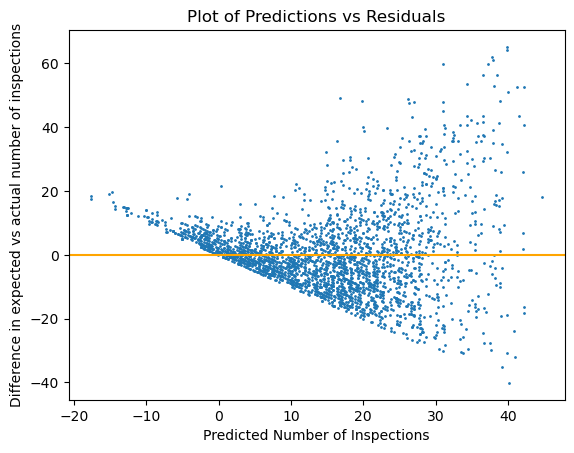

In [47]:
y_preds = lr1.predict(X1_transformed)

resids = (y1 - y_preds)

# Looking at a Scatterplot to check for equal variance of errors:
plt.scatter(y_preds, resids, s=1)
plt.title('Plot of Predictions vs Residuals')
plt.xlabel('Predicted Number of Inspections')
plt.ylabel('Difference in expected vs actual number of inspections')
plt.axhline(0, color="orange");

In [16]:
rf1 = RandomForestRegressor()
rf1.fit(X1_train_transformed, y1_train)
print(rf1.score(X1_train_transformed, y1_train))
print(rf1.score(X1_test_transformed, y1_test))    

0.7893543495511808
0.44322031454391253


In [17]:
et1 =ExtraTreesRegressor()
et1.fit(X1_train_transformed, y1_train)
print(et1.score(X1_train_transformed, y1_train))
print(et1.score(X1_test_transformed, y1_test))   

0.8243313162085231
0.20099809447507122


In [52]:
df1 = pd.read_csv('data/df1_with_weather1.csv')

In [53]:
df1.drop(columns=['TRAILERS'], inplace=True)
df1.dropna(inplace=True)

In [54]:
# Convert 'date1' to datetime
df1['DATE'] = pd.to_datetime(df1['DATE1'], format='%Y/%m/%d')

# Create 'month' and 'year' columns
df1['month'] = df1['DATE'].dt.month
df1['year'] = df1['DATE'].dt.year

In [55]:
df1.SHIFT_START = pd.to_datetime(df1.SHIFT_START, format='%H:%M')
df1.SHIFT_END = pd.to_datetime(df1.SHIFT_END)

In [56]:
df1['SHIFT_START_CATEGORY'] = pd.cut(pd.to_datetime(df1['SHIFT_START'], format='%H:%M').dt.hour,
                                    bins =[-1, 8, 11, 14, 17, 24],
                                    labels=['Early Morning', 'Morning', 'Afternoon', 'Late Afternoon', 'Evening'])
           

In [57]:
df1['SHIFT_END_CATEGORY'] = pd.cut(pd.to_datetime(df1['SHIFT_END'], format='%H:%M').dt.hour,
                                    bins =[-1, 8, 11, 14, 17, 19, 24],
                                    labels=['Early Morning', 'Morning', 'Afternoon', 'Late Afternoon', 'Evening', 'Night'])
                        

In [58]:
# Taking father's day out of the holiday weekend
holiday_list_weekends = ['2021-05-31', '2021-05-29', '2021-05-30', '2021-07-04', '2021-07-03', '2021-07-05', '2021-09-06', '2021-09-04', '2021-09-05',
                '2022-05-28', '2022-05-29', '2022-05-30', '2022-07-02', '2022-07-03', '2022-07-04', '2022-09-03', '2022-09-04',
                '2023-05-29', '2023-05-27', '2023-05-28', '2023-07-01', '2023-07-02', '2023-07-04', '2023-09-02', '2023-09-03', '2023-09-04']
df1['holiday']= np.where(df1['DATE'].isin(holiday_list_weekends), 1, 0)

In [59]:
X1 = df1.drop(columns=['DATE1', 'TOWN', 'WATERBODY', 'INSPECTOR_ID', 'TOTALINSP', 'DATE', 'SHIFT_START', 'SHIFT_END'])
y1 = df1.TOTALINSP            

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=42, test_size=.2)

In [60]:
categorical_columns = ['SITE_NAME', 'DAY_OF_WEEK', 'month', 'year', 'PAY_VOL', 'SHIFT_START_CATEGORY', 'SHIFT_END_CATEGORY']
oh = OneHotEncoder(handle_unknown='ignore', drop='first')
X1_train_transformed = oh.fit_transform(X1_train[categorical_columns])
X1_test_transformed= oh.transform(X1_test[categorical_columns])

In [146]:
with open('models/one_hot_encoder.pkl', 'wb') as file:
    pickle.dump(oh, file)

In [61]:
lr1 = LinearRegression()
lr1.fit(X1_train_transformed, y1_train)
print(lr1.score(X1_train_transformed, y1_train))
print(lr1.score(X1_test_transformed, y1_test))

0.42266411837465556
0.48353193229186


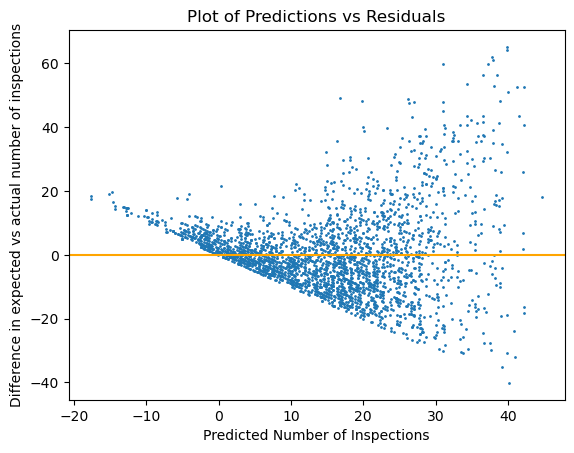

In [62]:
y_preds = lr1.predict(X1_transformed)

resids = (y1 - y_preds)

# Looking at a Scatterplot to check for equal variance of errors:
plt.scatter(y_preds, resids, s=1)
plt.title('Plot of Predictions vs Residuals')
plt.xlabel('Predicted Number of Inspections')
plt.ylabel('Difference in expected vs actual number of inspections')
plt.axhline(0, color="orange");

In [64]:
rf1 = RandomForestRegressor()
rf1.fit(X1_train_transformed, y1_train)
print(rf1.score(X1_train_transformed, y1_train))
print(rf1.score(X1_test_transformed, y1_test))   

0.7898948665450476
0.4360900674046402


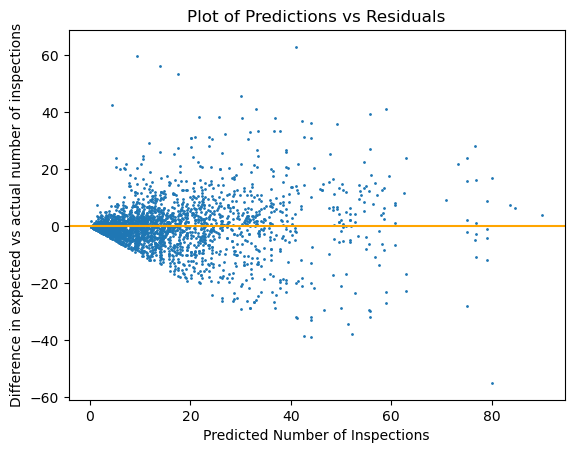

In [65]:
y_preds = rf1.predict(X1_transformed)

resids = (y1 - y_preds)

# Looking at a Scatterplot to check for equal variance of errors:
plt.scatter(y_preds, resids, s=1)
plt.title('Plot of Predictions vs Residuals')
plt.xlabel('Predicted Number of Inspections')
plt.ylabel('Difference in expected vs actual number of inspections')
plt.axhline(0, color="orange");

In [24]:
et1 =ExtraTreesRegressor()
et1.fit(X1_train_transformed, y1_train)
print(et1.score(X1_train_transformed, y1_train))
print(et1.score(X1_test_transformed, y1_test))   

0.8243313162085231
0.20358658024942067


### Progress Check-in
- Adding the weather data made a signficant improvement
    - Need to determine the best way to deal with the missing weather data (drop, backfill, fill with different station- not front fill)
- Adding the number of shifts worked by the inspector improved the tree based model
    - Should I use more feature engineering and further manipulate this data?
- Linear Regression is decent and not overfit: maybe not solid enough yet for a production model?
- Tree models very overfit, but random forest has a decent testing R2 and if overfit is reduced this may be a winning model

In [25]:
ada = AdaBoostRegressor()
ada.fit(X1_train_transformed, y1_train)
print(ada.score(X1_train_transformed, y1_train))
print(ada.score(X1_test_transformed, y1_test))

0.24823811280031027
0.22531614701299718


In [66]:
grad = GradientBoostingRegressor()
grad.fit(X1_train_transformed, y1_train)
print(grad.score(X1_train_transformed, y1_train))
print(grad.score(X1_test_transformed, y1_test))

0.5272917851498473
0.5208917615164887


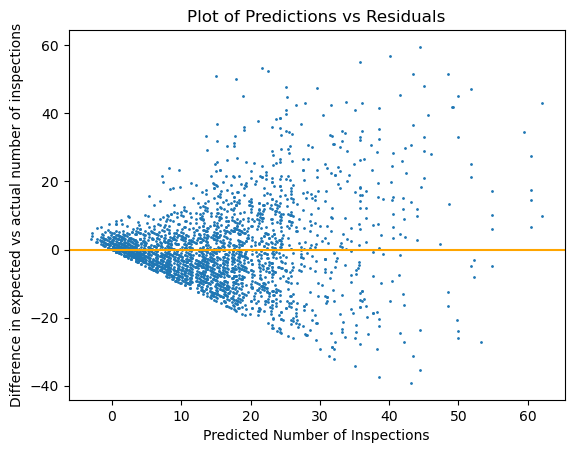

In [67]:
y_preds = grad.predict(X1_transformed)

resids = (y1 - y_preds)

# Looking at a Scatterplot to check for equal variance of errors:
plt.scatter(y_preds, resids, s=1)
plt.title('Plot of Predictions vs Residuals')
plt.xlabel('Predicted Number of Inspections')
plt.ylabel('Difference in expected vs actual number of inspections')
plt.axhline(0, color="orange");

In [ ]:
# Try some initial gridsearching/ random searching
# rf1 = RandomForestRegressor()
# rf1.fit(X1_train_transformed, y1_train)
# print(rf1.score(X1_train_transformed, y1_train))
# print(rf1.score(X1_test_transformed, y1_test))   


In [23]:
grad = GradientBoostingRegressor()

pgrid = {
    'estimator__learning_rate': [0.1, 1, 10],
    'estimator__n_estimators': [10, 100],
    'estimator__max_depth': [None, 1, 2, 3]
}

kf1 = KFold(n_splits=5, shuffle=True, random_state=42)
rs1 = RandomizedSearchCV(grad, pgrid, n_iter=500, cv=kf1, n_jobs=-1)

In [33]:
params = {
    'max_features': np.arange(5, X1.shape[1] + 1),
    'max_depth': np.append(np.arange(1, 20), None),
    'min_samples_leaf': np.append(np.arange(1, 15),   
}

gb = GradientBoostingRegressor(n_estimators=500, random_state = 42)

rs_gb = RandomizedSearchCV(gb, params, n_iter=100, cv = 5, n_jobs = -1, random_state=42)

In [34]:
%%time
rs_gb.fit(X1_train_transformed, y1_train)

C:\Users\kaitl\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
45 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kaitl\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kaitl\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\kaitl\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\kaitl\anaconda3\Lib\site-packages

CPU times: total: 1.69 s
Wall time: 2min 52s


RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingRegressor(n_estimators=500,
                                                       random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       None], dtype=object),
                                        'max_features': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, None], dtype=object)},
                   random_state=42)

In [35]:
print(f'Train Score: {rs_gb.score(X1_train_transformed, y1_train)}')
print(f'Test Score: {rs_gb.score(X1_test_transformed, y1_test)}')

Train Score: 0.6341147952714152
Test Score: 0.5488749413800318


In [37]:
rs_gb.best_params_

{'min_samples_leaf': 13, 'max_features': 5, 'max_depth': 5}

In [41]:
grad_1 = GradientBoostingRegressor(max_features=5, min_samples_leaf=13, max_depth=5, n_estimators=500, random_state=42)

In [82]:
%%time
grad_1.fit(X1_transformed, y1)

print(f'R2 Score: {grad_1.score(X1_transformed, y1)}')

R2 Score: 0.6310335648218146
CPU times: total: 328 ms
Wall time: 678 ms


In [145]:
# Pickling this model so that I can use it for predictions is a different workspace

with open('models/grad_1.pkl', 'wb') as file:
    pickle.dump(grad_1, file)

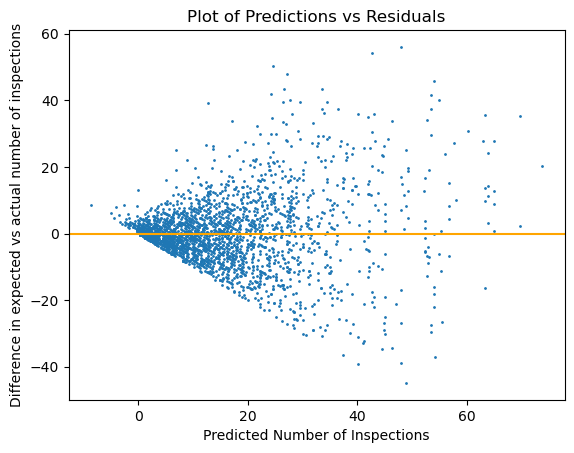

In [68]:
y_preds = grad_1.predict(X1_transformed)

resids = (y1 - y_preds)

# Looking at a Scatterplot to check for equal variance of errors:
plt.scatter(y_preds, resids, s=1)
plt.title('Plot of Predictions vs Residuals')
plt.xlabel('Predicted Number of Inspections')
plt.ylabel('Difference in expected vs actual number of inspections')
plt.axhline(0, color="orange");

Text(0, 0.5, 'Actual # Inspections')

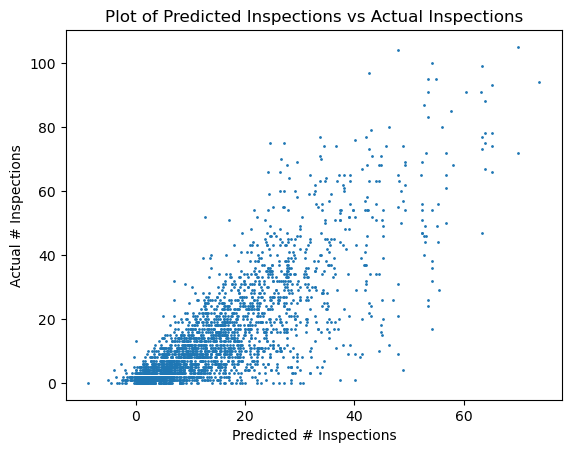

In [69]:
# Plot of Predicted vs actual
plt.scatter(y_preds, y1, s=1)
plt.title('Plot of Predicted Inspections vs Actual Inspections')
plt.xlabel('Predicted # Inspections')
plt.ylabel('Actual # Inspections')

In [70]:
sum(y_preds) - sum(y1)

-7.275957614183426e-11

In [33]:
params = {
    'max_features': np.arange(5, X1.shape[1] + 1),
    'max_depth': np.append(np.arange(1, 50), None),
    'min_samples_leaf': [2, 3],   
    'n_estimators': [50, 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

rf_gb = GradientBoostingRegressor(random_state = 42)

rf_gb_county_cases = RandomizedSearchCV(rf_gb, params, n_iter=100, cv = 5, n_jobs = -1)

In [34]:
%%time
rf_gb.fit(X1_train_transformed, y1_train)

CPU times: total: 3.23 s
Wall time: 22min 10s


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, None],
      dtype=object),
                                        'max_features': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'min_samples_leaf': [2, 3],
                                        'n_estimators': [50, 100, 200, 400, 600,
                                                         800, 1000, 1200, 1400,
                                                         1600, 1800, 2000]})

In [35]:
print(f'Train Score: {rf_gb.score(X1_train_transformed, y1_train)}')
print(f'Test Score: {rf_gb.score(X1_test_transformed, y1_test)}')

Train Score: 0.6150099401370822
Test Score: 0.5473442855804718


In [38]:
# Try retraining on all of the data
X1_transformed = oh.fit_transform(X1[categorical_columns])


In [39]:
print(f'Train Score: {rf_gb.score(X1_transformed, y1)}')

NameError: name 'rf_gb' is not defined

In [36]:
rf_gb.best_params_

{'n_estimators': 600,
 'min_samples_leaf': 2,
 'max_features': 10,
 'max_depth': 3}

In [35]:
params = {
    'max_features': np.arange(1, X1.shape[1] + 1), 
    'max_depth': np.append(np.arange(1, 10), None), 
    'min_samples_leaf': np.arange(1, 31) 
}
kf = KFold(n_splits=5, shuffle=True, random_state=2023)
ranfor = RandomForestRegressor(
    n_estimators=200,
    random_state=2023
)

rs2 = RandomizedSearchCV(ranfor, params, n_iter=400, cv=kf, n_jobs=-1, random_state=42)

In [36]:
%%time
rs2.fit(X1_train_transformed, y1_train)

CPU times: total: 6.89 s
Wall time: 3min 45s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=2023, shuffle=True),
                   estimator=RandomForestRegressor(n_estimators=200,
                                                   random_state=2023),
                   n_iter=400, n_jobs=-1,
                   param_distributions={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9, None], dtype=object),
                                        'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])})

In [37]:
print(rs2.score(X1_train_transformed, y1_train))
print(rs2.score(X1_test_transformed, y1_test))

0.6234446377700327
0.5191355632175731


In [30]:
rs2.best_params_

{'min_samples_leaf': 4, 'max_features': 14, 'max_depth': 7}

In [38]:
rs2.best_params_

{'min_samples_leaf': 3, 'max_features': 14, 'max_depth': None}

In [39]:
params = {
    'max_features': np.arange(1, X1.shape[1] + 1), 
    'max_depth': np.append(np.arange(1, 10), None), 
    'min_samples_leaf': np.arange(1, 31) 
}
kf = KFold(n_splits=5, shuffle=True, random_state=2023)
ranfor = ExtraTreesRegressor(
    n_estimators=200,
    random_state=2023
)

rs3 = RandomizedSearchCV(ranfor, params, n_iter=100, cv=kf, n_jobs=-1, random_state=42)

In [41]:
rs3.fit(X1_train_transformed, y1_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=2023, shuffle=True),
                   estimator=ExtraTreesRegressor(n_estimators=200,
                                                 random_state=2023),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9, None], dtype=object),
                                        'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])},
                   random_state=42)

In [43]:
print(rs3.score(X1_train_transformed, y1_train))
print(rs3.score(X1_test_transformed, y1_test))

0.5159039609428526
0.4949398686056966


In [25]:
# More modeling after fixing issues with SITE_NAME
df2 = pd.read_csv('data/df2_with_weather.csv')
df2.drop(columns=['TRAILERS'], inplace=True)
df2.dropna(inplace=True)

In [26]:
X2 = df2.drop(columns=['DATE1', 'TOWN', 'WATERBODY', 'INSPECTOR_ID', 'TOTALINSP', 'DATE', 'SHIFT_START', 'SHIFT_END'])
y2 = df2.TOTALINSP            

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=42, test_size=.2)

In [27]:
categorical_columns = ['SITE_NAME', 'DAY_OF_WEEK', 'month', 'year', 'PAY_VOL', 'SHIFT_START_CATEGORY', 'SHIFT_END_CATEGORY']
oh = OneHotEncoder(handle_unknown='ignore', drop='first')
X2_train_transformed = oh.fit_transform(X2_train[categorical_columns])
X2_test_transformed= oh.transform(X2_test[categorical_columns])

In [109]:
lr2 = LinearRegression()
lr2.fit(X2_train_transformed, y2_train)
print(lr2.score(X2_train_transformed, y2_train))
print(lr2.score(X2_test_transformed, y2_test))

0.41892295489341824
0.3945029779824951


In [110]:
rf2 = RandomForestRegressor()
rf2.fit(X2_train_transformed, y2_train)
print(rf2.score(X2_train_transformed, y2_train))
print(rf2.score(X2_test_transformed, y2_test))    

0.7686827904670492
0.38907189776765183


In [111]:
grad = GradientBoostingRegressor()
grad.fit(X2_train_transformed, y2_train)
print(grad.score(X2_train_transformed, y2_train))
print(grad.score(X2_test_transformed, y2_test))

0.5142276335273501
0.4618525960583473


In [112]:
grad_1 = GradientBoostingRegressor(max_features=5, min_samples_leaf=13, max_depth=5, n_estimators=500, random_state=42)

In [28]:
X2_transformed = oh.fit_transform(X2[categorical_columns])

In [114]:
%%time
grad_1.fit(X2_transformed, y2)

print(f'R2 Score: {grad_1.score(X2_transformed, y2)}')

R2 Score: 0.6313783856715871
CPU times: total: 500 ms
Wall time: 608 ms


In [125]:
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline
from scipy.stats import uniform
from sklearn.compose import ColumnTransformer

In [129]:
df2 = pd.read_csv('data/df2_with_weather.csv')
df2.drop(columns=['TRAILERS'], inplace=True)
df2.dropna(inplace=True)

# Assume df1 is meant to be df2 in your provided code
X2 = df2.drop(columns=['DATE1', 'TOWN', 'WATERBODY', 'INSPECTOR_ID', 'TOTALINSP', 'DATE', 'SHIFT_START', 'SHIFT_END'])
y2 = df2['TOTALINSP']

# Specify categorical columns
categorical_columns = ['SITE_NAME', 'DAY_OF_WEEK', 'month', 'year', 'PAY_VOL', 'SHIFT_START_CATEGORY', 'SHIFT_END_CATEGORY']

# Specify numerical columns
numerical_columns = [col for col in X2.columns if col not in categorical_columns]

# Split the data into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=42, test_size=.2)

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numerical_columns),
        ('categorical', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_columns)
    ],
    remainder='passthrough'  # Keep columns not specified in transformers as they are
)

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures()),
    ('regressor', LinearRegression())
])

# Define hyperparameters for RandomizedSearchCV
param_dist = {
    'poly__degree': [1, 2, 3, 4],
    'regressor__fit_intercept': [True, False],
    'regressor__positive': [True, False]
}

# Create and fit the RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    scoring='r2',
    cv=5,
    random_state=42
)

random_search.fit(X2_train, y2_train)

# Print the best parameters and the corresponding R^2 score
print("Best Parameters:", random_search.best_params_)
print("Best R^2 Score:", random_search.best_score_)

# Evaluate the model on the test set
test_score = random_search.score(X2_test, y2_test)
print("Test Set R^2 Score:", test_score)

Best Parameters: {'regressor__positive': False, 'regressor__fit_intercept': True, 'poly__degree': 1}
Best R^2 Score: 0.44578806734809734
Test Set R^2 Score: 0.4224033322296722


C:\Users\kaitl\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kaitl\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kaitl\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kaitl\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.fit

In [136]:
%%time

#Re-run with regularization

# Load your data
df2 = pd.read_csv('data/df2_with_weather.csv')

df2.drop(columns=['TRAILERS'], inplace=True)
df2.dropna(inplace=True)

# Assume df1 is meant to be df2 in your provided code
X2 = df2.drop(columns=['DATE1', 'TOWN', 'WATERBODY', 'INSPECTOR_ID', 'TOTALINSP', 'DATE', 'SHIFT_START', 'SHIFT_END'])
y2 = df2['TOTALINSP']

# Specify categorical columns
categorical_columns = ['SITE_NAME', 'DAY_OF_WEEK', 'month', 'year', 'PAY_VOL', 'SHIFT_START_CATEGORY', 'SHIFT_END_CATEGORY']

# Specify numerical columns
numerical_columns = [col for col in X2.columns if col not in categorical_columns]

# Split the data into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=42, test_size=.2)

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numerical_columns),
        ('categorical', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_columns)
    ],
    remainder='passthrough'  # Keep columns not specified in transformers as they are
)

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures()),
    ('regressor', ElasticNet(max_iter=1000))
])

# Define hyperparameters for RandomizedSearchCV
param_dist = {
    'poly__degree': [1, 2, 3, 4],
    'regressor__alpha': uniform(loc=0.01, scale=1.0),  # Regularization strength
    'regressor__l1_ratio': [0.1, 0.5, 0.7, .8, 0.9]
}

# Create and fit the RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=100,
    scoring='r2',
    cv=5,
    random_state=42
)

random_search.fit(X2_train, y2_train)

# Print the best parameters and the corresponding R^2 score
print("Best Parameters:", random_search.best_params_)
print("Best R^2 Score:", random_search.best_score_)

# Evaluate the model on the test set
test_score = random_search.score(X2_test, y2_test)
print("Test Set R^2 Score:", test_score)

C:\Users\kaitl\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19678.658039495, tolerance: 44.02013820754718
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\kaitl\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2626.79212445367, tolerance: 42.158122035040435
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\kaitl\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2321.9325536328834, tolerance: 43.43145417789758
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\kaitl\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:58

Best Parameters: {'poly__degree': 2, 'regressor__alpha': 0.01919705161662965, 'regressor__l1_ratio': 0.1}
Best R^2 Score: 0.5850595480781158
Test Set R^2 Score: 0.5873801164767164
CPU times: total: 10h 35min 8s
Wall time: 8h 18min 50s


The above cell took 8h18 min to run without parallelization. 
Best Parameters: {'poly__degree': 2, 'regressor__alpha': 0.01919705161662965, 'regressor__l1_ratio': 0.1}
Best R^2 Score: 0.5850595480781158
Test Set R^2 Score: 0.5873801164767164
CPU times: total: 10h 35min 8s
Wall time: 8h 18min 50s

Adding polynomial features and regularization is a significant improvement over the basic linear model.

In [139]:
# Print the best parameters and the corresponding R^2 score
print("Best Parameters:", random_search.best_params_)
print("Best R^2 Score:", random_search.best_score_)

# Evaluate the model on the test set
test_score = random_search.score(X2_test, y2_test)
print("Test Set R^2 Score:", test_score)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [140]:
%%time

#Re-run with regularization

# Load your data
df2 = pd.read_csv('data/df2_with_weather.csv')

df2.drop(columns=['TRAILERS'], inplace=True)
df2.dropna(inplace=True)

# Assume df1 is meant to be df2 in your provided code
X2 = df2.drop(columns=['DATE1', 'TOWN', 'WATERBODY', 'INSPECTOR_ID', 'TOTALINSP', 'DATE', 'SHIFT_START', 'SHIFT_END'])
y2 = df2['TOTALINSP']

# Specify categorical columns
categorical_columns = ['SITE_NAME', 'DAY_OF_WEEK', 'month', 'year', 'PAY_VOL', 'SHIFT_START_CATEGORY', 'SHIFT_END_CATEGORY']

# Specify numerical columns
numerical_columns = [col for col in X2.columns if col not in categorical_columns]

# Split the data into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=42, test_size=.2)

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_columns)
    ],
    remainder='passthrough'  # Keep columns not specified in transformers as they are
)

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures()),
    ('regressor', ElasticNet(max_iter=3000, selection='random'))
])

# Define hyperparameters for RandomizedSearchCV
param_dist = {
    'poly__degree': [1, 2, 3, 4],
    'regressor__alpha': uniform(loc=0.0001, scale=1.0),
    'regressor__l1_ratio': [.001, 0.1, 0.5, 0.7]
}

# Create and fit the RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    scoring='r2',
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X2_train, y2_train)

# Print the best parameters and the corresponding R^2 score
print("Best Parameters:", random_search.best_params_)
print("Best R^2 Score:", random_search.best_score_)

# Evaluate the model on the test set
test_score = random_search.score(X2_test, y2_test)
print("Test Set R^2 Score:", test_score)

Best Parameters: {'poly__degree': 2, 'regressor__alpha': 0.05651157902710026, 'regressor__l1_ratio': 0.7}
Best R^2 Score: 0.5551055926149194
Test Set R^2 Score: 0.5526398756335907
CPU times: total: 5.56 s
Wall time: 47min 25s


C:\Users\kaitl\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107495.8671887767, tolerance: 54.29999223719676
  model = cd_fast.sparse_enet_coordinate_descent(


In [33]:
%%time

param_dist = {
    'n_estimators': np.arange(10, 400),
    'max_features': ['sqrt', 'log2', None],  # Use 'sqrt' instead of 'auto'
    'max_depth': [None, 3, 5, 7, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
    'min_samples_split': np.arange(2, 20),
    'min_samples_leaf': np.arange(1, 20),
    'bootstrap': [True, False]
}

# Create a Random Forest Regressor
rf = RandomForestRegressor()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    rf, 
    param_distributions=param_dist, 
    n_iter=500,  # Number of parameter settings that are sampled
    cv=5,  # Number of folds in a (Stratified)KFold
    scoring='r2',  # Scoring metric
    verbose=1, 
    n_jobs=3  # Use all available CPU cores
)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X2_train_transformed, y2_train)

# Print the best parameters and R^2 score
print("Best Parameters:", random_search.best_params_)
print("Best R^2 Score:", random_search.best_score_)

# You can access the best model using random_search.best_estimator_
best_rf_model = random_search.best_estimator_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best Parameters: {'n_estimators': 229, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': True}
Best R^2 Score: 0.42942538216464277
CPU times: total: 4.58 s
Wall time: 17min 53s


In [40]:
grad = GradientBoostingRegressor()

pgrid = {
    'estimator__learning_rate': [0.1, 1, 10],
    'estimator__n_estimators': [10, 100],
    'estimator__max_depth': [None, 1, 2, 3]
}

kf1 = KFold(n_splits=5, shuffle=True, random_state=42)
rs1 = RandomizedSearchCV(grad, pgrid, n_iter=500, cv=kf1, n_jobs=2)

In [37]:
params = {
    'max_features': np.arange(5, X2.shape[1] + 1),
    'max_depth': np.append(np.arange(1, 50), None),
    'min_samples_leaf': [2, 3],   
    'n_estimators': [50, 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

rf_gb = GradientBoostingRegressor(random_state = 42)

rf_gb = RandomizedSearchCV(rf_gb, params, n_iter=100, cv = 5, n_jobs = 2)

In [38]:
%%time
rf_gb.fit(X2_train_transformed, y2_train)
print(rf_gb.score(X2_train_transformed, y2_train))
print(rf_gb.score(X2_test_transformed, y2_test))

0.5930505722039463
0.5117579050003868
CPU times: total: 1.06 s
Wall time: 34min 13s


In [42]:
%%time 
rs1.fit(X2_train_transformed, y2_train)
print(rs1.score(X2_train_transformed, y_train))
print(rs1.score(X2_test_transformed, y2_test))

C:\Users\kaitl\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 24 is smaller than n_iter=500. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


ValueError: Invalid parameter 'estimator' for estimator GradientBoostingRegressor(). Valid parameters are: ['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'].

In [18]:
df = pd.read_csv('data/df3_with_weather.csv')

In [19]:
df.drop(columns=['TRAILERS'], inplace=True)
df.dropna(inplace=True)

In [20]:
X3 = df.drop(columns=['DATE1', 'TOWN', 'WATERBODY', 'INSPECTOR_ID', 'TOTALINSP', 'DATE', 'SHIFT_START', 'SHIFT_END'])
y3 = df.TOTALINSP            

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state=42, test_size=.2)

In [21]:
categorical_columns = ['SITE_NAME', 'DAY_OF_WEEK', 'month', 'year', 'PAY_VOL', 'SHIFT_START_CATEGORY', 'SHIFT_END_CATEGORY']
oh = OneHotEncoder(handle_unknown='ignore', drop='first')
X3_train_transformed = oh.fit_transform(X3_train[categorical_columns])
X3_test_transformed= oh.transform(X3_test[categorical_columns])

In [22]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('regressor', ElasticNet(alpha=0.01919705161662965, l1_ratio=0.1))
])

# Fit the model on the training data
pipeline.fit(X3_train_transformed, y3_train)

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('regressor',
                 ElasticNet(alpha=0.01919705161662965, l1_ratio=0.1))])

In [23]:
print(pipeline.score(X3_train_transformed, y3_train))
print(pipeline.score(X3_test_transformed, y3_test))

0.5345644705129942
0.48352970779111637


In [24]:
grad = GradientBoostingRegressor()

grad.fit(X3_train_transformed, y3_train)

print(grad.score(X3_train_transformed, y3_train))
print(grad.score(X3_test_transformed, y3_test))

0.5142276335273501
0.4618525960583473
